In [ ]:
!pip install torch transformers tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 7.8 MB/s 
     |████████████████████████████████| 596 kB 11.6 MB/s 
     |████████████████████████████████| 6.6 MB 48.6 MB/s 
     |████████████████████████████████| 101 kB 8.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import re
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import matplotlib.pyplot  as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

from transformers import AutoTokenizer, AutoModel
from transformers import BertModel, BertForSequenceClassification

device = "cuda" if torch.cuda.is_available() else "cpu"


In [ ]:
class TwitterDataset(Dataset):
    def __init__(self, df, tokenizer, max_length = 110):
        super(TwitterDataset, self).__init__()
        self.max_length = max_length

        tweets = self.preprocess(df)
        tweets = df.text.tolist()
        labels = df.target.to_list()
        
        tokens = tokenizer(tweets, return_tensors='pt', max_length=self.max_length, padding=True, truncation=True).to(device)
        
        self.ids = tokens['input_ids']
        self.mask = tokens['attention_mask']
        
        self.labels = torch.Tensor(labels).to(device)


    @classmethod
    def preprocess(cls, df):
        # df = cls._add_subject(df)
        tweets = cls._basic_cleanup(df.text.to_list())
        return tweets

    @staticmethod
    def _basic_cleanup(corpus_list):
        cleaned_corpus = []
        for tweet in corpus_list:
            tweet  = tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','url',tweet)
            tweet = tweet.replace('@', '')
            tweet = re.sub('[\n]+', ' ', tweet)
            tweet = re.sub(' +', ' ', tweet)
            cleaned_corpus.append(tweet)

        return cleaned_corpus
    
    @staticmethod
    def _add_subject(df):
        df_bols = df[df.subject=='bolsonaro'].copy()
        df_lula = df[df.subject=='lula'].copy()
        df_bols.text = ['bolsonaro ' + tweet for tweet in df_bols[df_bols.subject=='bolsonaro'].text.tolist()]
        df_lula.text = ['lula ' + tweet for tweet in df_lula[df_lula.subject=='lula'].text.tolist()]
        return pd.concat([df_lula, df_bols]).reset_index(drop=True)


    def __len__(self):
        return len(self.ids)

    def __getitem__(self, index):
        return (self.ids[index], self.mask[index], self.labels[index])



class BERTModel(nn.Module):
    
    def __init__(self, checkpoint, pass_gradients = False):
        super(BERTModel, self).__init__()

        # Bert
        self.bert = self._load_bert_(checkpoint, pass_gradients)
       
        # Classification Head
        self.l1 = nn.Linear(768, 256)
        self.l2 = nn.Linear(256, 64)
        self.l3 = nn.Linear(64, 1)

    def _load_bert_(self, checkpoint, pass_gradients):
        bert = BertModel.from_pretrained(checkpoint)
        if not pass_gradients:
            for param in bert.parameters():
                param.requires_grad = False
        return bert
    

    def forward(self, ids, mask):
        bert_output = self.bert(ids, mask)
        seq = bert_output['last_hidden_state']
        out = self.l1(seq[:, 0, :].view(-1, 768))
        out = self.l2(out)
        out = self.l3(out)
        return torch.sigmoid(out)


def evaluate(model, data_loader, threshold=0.5, on_loop = True):
   
    sum_loss = 0
    logits_bag, labels_bag = [], []
    
    with tqdm(data_loader) as tqdm_val:
        for i, batch in enumerate(tqdm_val):
            tqdm_val.set_description(f"Evaluation")
            ids, mask, labels = batch
            
            with torch.no_grad():        
                output = model(ids=ids, mask=mask).squeeze()

            # Compute Loss
            loss = criterion(output, labels)
            sum_loss += loss.item()
            loss_train_avg = sum_loss/ (i+1)

            logits = output.cpu().detach().numpy()
            labels = labels.detach().cpu().numpy()
            logits_bag.append(logits)
            labels_bag.append(labels)

            tqdm_val.set_postfix(
                {
                'loss' : loss_train_avg, 
                }
            )

        
        logits_bag = np.concatenate(logits_bag, axis=0)
        labels_bag = np.concatenate(labels_bag, axis=0)
        predictions = np.where(np.array(logits_bag) > threshold,1,0)
        loss_avg = sum_loss/len(data_loader) 
        report = classification_report(labels_bag, predictions, target_names=['Negative', 'Positive'])
        loss_avg = sum_loss/len(data_loader) 

        print(f'\tComputed Loss: {loss_avg:.3f}')
        if on_loop:
            print(f'\tAccuracy: {accuracy_score(labels_bag, predictions):.3f}\n')
            return loss_avg, accuracy_score(labels_bag, predictions)
        
        print()
        print(report)   
        return logits_bag, predictions



def plot_history(history):
    x_values = range(len(history['epoch_losses_val']))
    fig, ax = plt.subplots(1,2, figsize = (18,7))

    # Plots
    ax[0].plot(x_values, history['epoch_losses_train'], color='b', label='Train')
    ax[0].plot(x_values, history['epoch_losses_val'], color='red', label='Val')
    ax[1].plot(x_values, history['epoch_acc_val'], color='black', label='Val Accuracy')

    ax[0].set_title('Loss')
    ax[1].set_title('Accurary')
    plt.legend()



def early_stopping(epoch_losses, pacience = 3, tol = 0.02):
    '''
    Model has to improve at least "tol" in "pacience" epochs.
    '''
    if len(epoch_losses) >= pacience:
        improvement = abs(epoch_losses[-pacience] - epoch_losses[-1])
        if improvement < tol:
            return True
    return False


CHECKPOINT = "neuralmind/bert-base-portuguese-cased"

batch_size = 32
epochs = 30
max_length = 512 #115

# Learning rate
lr_init = 1.5e-3
gamma = 0.95

# Early stopping
pacience = 5
tol = 0.01




df = pd.read_parquet('../../data/2-intermediate/labels.parquet')

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(CHECKPOINT)

# Model
model = BERTModel(CHECKPOINT)
model.to(device)

# Schuduler and Optmizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr_init)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = gamma)
criterion = nn.BCELoss()



# Split
tweets_train, tweets_test = train_test_split(df, test_size=0.2, random_state=42)
tweets_val, tweets_test = train_test_split(df, test_size=0.5, random_state=42)

# Data Loaders
train_dataset = TwitterDataset(tweets_train, tokenizer, max_length=max_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True)

val_dataset = TwitterDataset(tweets_val, tokenizer, max_length=max_length)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

test_dataset = TwitterDataset(tweets_test, tokenizer, max_length=max_length)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluation: 100%|██████████| 36/36 [00:33<00:00,  1.07it/s, loss=0.634]


	Computed Loss: 0.634
	Accuracy: 0.652



Evaluation: 100%|██████████| 36/36 [00:33<00:00,  1.06it/s, loss=0.61]


	Computed Loss: 0.610
	Accuracy: 0.658



Evaluation: 100%|██████████| 36/36 [00:34<00:00,  1.05it/s, loss=0.591]


	Computed Loss: 0.591
	Accuracy: 0.682



Evaluation: 100%|██████████| 36/36 [00:34<00:00,  1.06it/s, loss=0.584]


	Computed Loss: 0.584
	Accuracy: 0.697



Evaluation: 100%|██████████| 36/36 [00:34<00:00,  1.06it/s, loss=0.562]


	Computed Loss: 0.562
	Accuracy: 0.704



Evaluation: 100%|██████████| 36/36 [00:33<00:00,  1.06it/s, loss=0.569]


	Computed Loss: 0.569
	Accuracy: 0.701



Evaluation: 100%|██████████| 36/36 [00:33<00:00,  1.06it/s, loss=0.566]


	Computed Loss: 0.566
	Accuracy: 0.701



Evaluation: 100%|██████████| 36/36 [00:34<00:00,  1.06it/s, loss=0.557]


	Computed Loss: 0.557
	Accuracy: 0.707



Evaluation: 100%|██████████| 36/36 [00:34<00:00,  1.06it/s, loss=0.542]


	Computed Loss: 0.542
	Accuracy: 0.722



Evaluation: 100%|██████████| 36/36 [00:34<00:00,  1.06it/s, loss=0.531]


	Computed Loss: 0.531
	Accuracy: 0.731



Evaluation: 100%|██████████| 36/36 [00:34<00:00,  1.06it/s, loss=0.526]


	Computed Loss: 0.526
	Accuracy: 0.734



Evaluation: 100%|██████████| 36/36 [00:34<00:00,  1.06it/s, loss=0.544]


	Computed Loss: 0.544
	Accuracy: 0.728



Evaluation: 100%|██████████| 36/36 [00:34<00:00,  1.06it/s, loss=0.527]


	Computed Loss: 0.527
	Accuracy: 0.736



Evaluation: 100%|██████████| 36/36 [00:34<00:00,  1.06it/s, loss=0.523]


	Computed Loss: 0.523
	Accuracy: 0.732




Early stopping - Validation Loss = 0.523, Validation Accuracy = 0.732


Results on Test:


Evaluation: 100%|██████████| 36/36 [00:29<00:00,  1.22it/s, loss=0.582]


	Computed Loss: 0.582

              precision    recall  f1-score   support

    Negative       0.73      0.62      0.67       561
    Positive       0.68      0.79      0.73       585

    accuracy                           0.70      1146
   macro avg       0.71      0.70      0.70      1146
weighted avg       0.71      0.70      0.70      1146



Train Summary:


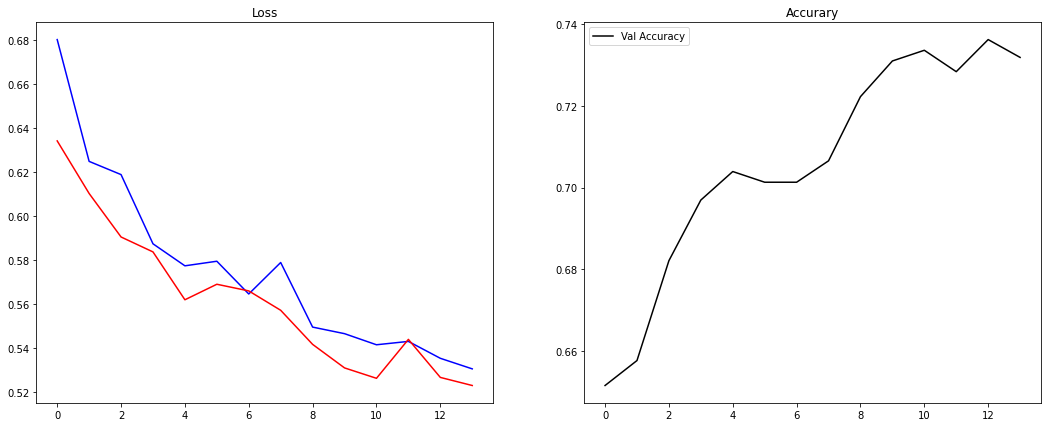

In [7]:

history = {
    'epoch_losses_train':[],
    'epoch_losses_val':[],
    'epoch_acc_val':[],
}

for epoch in range(epochs):    
    with tqdm(train_loader) as tqdm_epoch:
        sum_loss = 0
        
        for i, batch in enumerate(tqdm_epoch):
            tqdm_epoch.set_description(f"EPOCH {epoch}")
        
            ids, mask, labels = batch
            
            # Forward
            output = model(ids=ids, mask=mask).squeeze()
            loss = criterion(output, labels)

            # Backward
            optimizer.zero_grad() 
            loss.backward()
            optimizer.step()
            
            # Compute Loss
            sum_loss += loss.item()
            loss_train_avg = sum_loss/ (i+1)

            tqdm_epoch.set_postfix(
                {
                'loss' : loss_train_avg, 
                'lr' : round(scheduler.get_last_lr()[0],5)
                }
            )

        history['epoch_losses_train'].append(loss_train_avg)
        scheduler.step()

        # Evaluate
        loss_val, acc_val = evaluate(model, val_loader)
        history['epoch_losses_val'].append(loss_val)
        history['epoch_acc_val'].append(acc_val)

        # Early Stopping
        if early_stopping(history['epoch_losses_val'], pacience = pacience, tol = tol):
            print(f'\n\n\nEarly stopping - Validation Loss = {loss_val:.3f}, Validation Accuracy = {acc_val:.3f}')
            break

print('\n\nResults on Test:')
logits_bag, predictions = evaluate(model, test_loader, on_loop=False)

print('\n\nTrain Summary:')
plot_history(history)